# Import the necessary packages

In [14]:
import pandas as pd
import tensorflow
import keras

In [15]:
# Load the dataset

data = pd.read_csv("Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [16]:
# Extract the required columns

reviews = data[['text', 'airline_sentiment']]
print(reviews.shape)
reviews.head()

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [17]:
# Binary Classification - Positive & Negative, so drop the Neutral reviews

reviews = reviews[reviews['airline_sentiment'] != 'neutral']

print(reviews.shape)
reviews.head()

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [18]:
reviews['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

# Data Preprocessing

In [26]:
# Converting the categorical sentiment values to numeric values using factorize() method
# 0: Positive Sentiment, 1: Negative Sentiment

sentiment = reviews.airline_sentiment.factorize()
print(sentiment)

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64), Index(['positive', 'negative'], dtype='object'))


In [50]:
# Tokenizing the Text Data
# fit_on_text() - to associate the words with the numbers
# texts_to_sequences() - to replace the words with numbers/tokens

from keras.preprocessing.text import Tokenizer

tweet = reviews.text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1 # input dim for the Embedding layer
tokens = tokenizer.texts_to_sequences(tweet)

print(tweet[0])
print(tokens[0])
print(vocab_size)

@VirginAmerica plus you've added commercials to the experience... tacky.
[103, 575, 530, 1287, 2416, 1, 2, 177]
13234


In [51]:
# Padding the sentences

from keras.preprocessing.sequence import pad_sequences

tokens_padded = pad_sequences(tokens, maxlen=200)
tokens_padded

array([[   0,    0,    0, ...,    1,    2,  177],
       [   0,    0,    0, ...,   25,  482, 2417],
       [   0,    0,    0, ...,  483,   86,   21],
       ...,
       [   0,    0,    0, ...,    8,    1,  480],
       [   0,    0,    0, ..., 1682,   45,  945],
       [   0,    0,    0, ...,  144,   11, 2325]])

# Building the Classifier Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           423488    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
_________________________________________________________________
None


# Training the model

In [53]:
# Num of epochs = 5, batch size = 32, validation split = 20%

history = model.fit(tokens_padded, sentiment[0], validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 60s 196ms/step - loss: 0.3838 - accuracy: 0.8396 - val_loss: 0.1989 - val_accuracy: 0.9255
Epoch 2/5
289/289 [==============================] - 57s 198ms/step - loss: 0.2158 - accuracy: 0.9163 - val_loss: 0.1773 - val_accuracy: 0.9372
Epoch 3/5
289/289 [==============================] - 57s 198ms/step - loss: 0.1648 - accuracy: 0.9394 - val_loss: 0.1693 - val_accuracy: 0.9385
Epoch 4/5
289/289 [==============================] - 58s 202ms/step - loss: 0.1568 - accuracy: 0.9409 - val_loss: 0.1679 - val_accuracy: 0.9441
Epoch 5/5
289/289 [==============================] - 58s 202ms/step - loss: 0.1145 - accuracy: 0.9572 - val_loss: 0.1975 - val_accuracy: 0.9433


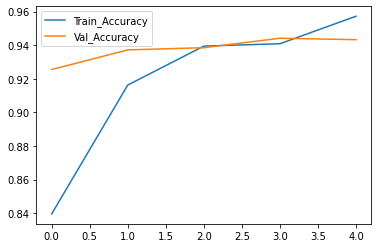

<Figure size 432x288 with 0 Axes>

In [58]:
# Plotting & analyzing the accuracy & loss

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train_Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy Plot.jpg')

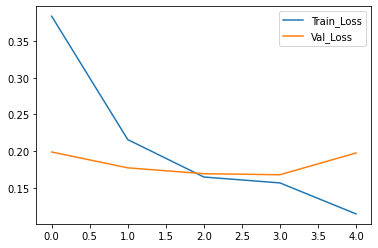

<Figure size 432x288 with 0 Axes>

In [59]:
plt.plot(history.history['loss'], label='Train_Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()
plt.savefig('Loss Plot.jpg')

In [66]:
# Using the model to make predictions

def predict(text):
    token1 = tokenizer.texts_to_sequences([text])
    token1 = pad_sequences(token1, maxlen=200)
    prediction = int(model.predict(token1).round().item())
    print("Predicted Sentiment: ", sentiment[1][prediction])


test_data1 = "I was glad to play after a long time!"
predict(test_data1)

test_data2 = "The food they serve on the trains is the worst."
predict(test_data2)

Predicted Sentiment:  positive
Predicted Sentiment:  negative
